In [2]:
import os
import zipfile
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import random
from tensorflow import keras
from tensorflow.keras import layers
import nibabel as nib
from scipy import ndimage

In [2]:

def read_nifti_file(filepath):
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    min = -1000
    max = 400
    volume[volume<min] = min
    volume[volume>max] = max
    volume = (volume-min)/(max-min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    
    depth = current_depth/desired_depth
    width = current_width/desired_width
    height = current_height/desired_height
    
    depth_factor = 1/depth
    width_factor = 1/width
    height_factor = 1/height
    
    img = ndimage.rotate(img, 90, reshape = False)
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order = 1)
    return img

def process_scan(path):
    volume = read_nifti_file(path)
    volume = normalize(volume)
    volume = resize_volume(volume)
    return volume

In [3]:
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]
# Folder "CT-23" consist of CT scans having several ground-glass opacifications,
# involvement of lung parenchyma.
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


In [5]:
ct_scan1 = read_nifti_file(normal_scan_paths[0])

In [7]:
max_ = np.max(np.array(ct_scan1))
min_ = np.min(np.array(ct_scan1))


In [8]:
ct_scan1 = (ct_scan1-min_)/(max_-min_)

In [15]:
ct_scan1.shape

(512, 512, 43)

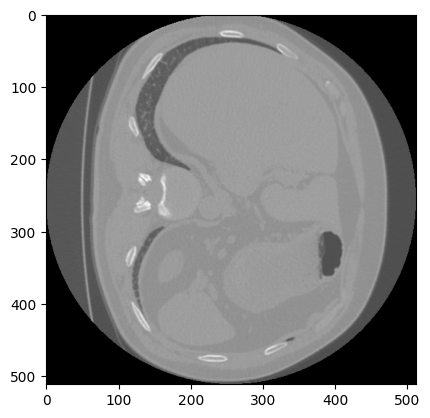

In [23]:
plt.imshow(ct_scan1[:, :, 6], cmap = "gray")

In [4]:
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

In [5]:
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis = 0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis = 0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis = 0)

print("Number of samples in train and validation are %d and %d" %(x_train.shape[0], x_val.shape[0]))

Number of samples in train and validation are 140 and 60


In [6]:
@tf.function
def rotate(volume):
    def scipy_rotate(volume):
        angles = [-20, -10, -5, 5, 10, 20]
        angle = random.choice(angles)
        volume = ndimage.rotate(volume, angle, reshape = False)
        volume[volume<0] = 0
        volume[volume>1]  = 1
        return volume
    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

def train_preprocessing(volume, label):
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

def validation_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [7]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
train_dataset = train_loader.shuffle(len(x_train)).map(train_preprocessing, num_parallel_calls = tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_loader.shuffle(len(x_val)).map(validation_preprocessing, num_parallel_calls = tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Dimension of the CT scan is: (128, 128, 64, 1)


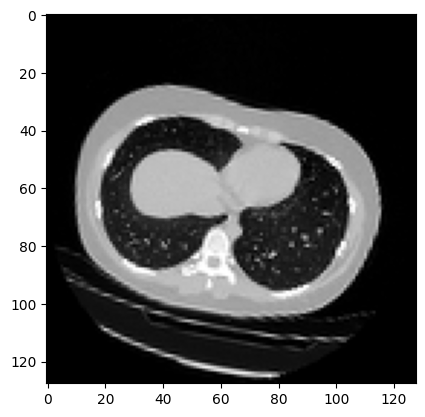

In [10]:
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap ="gray")

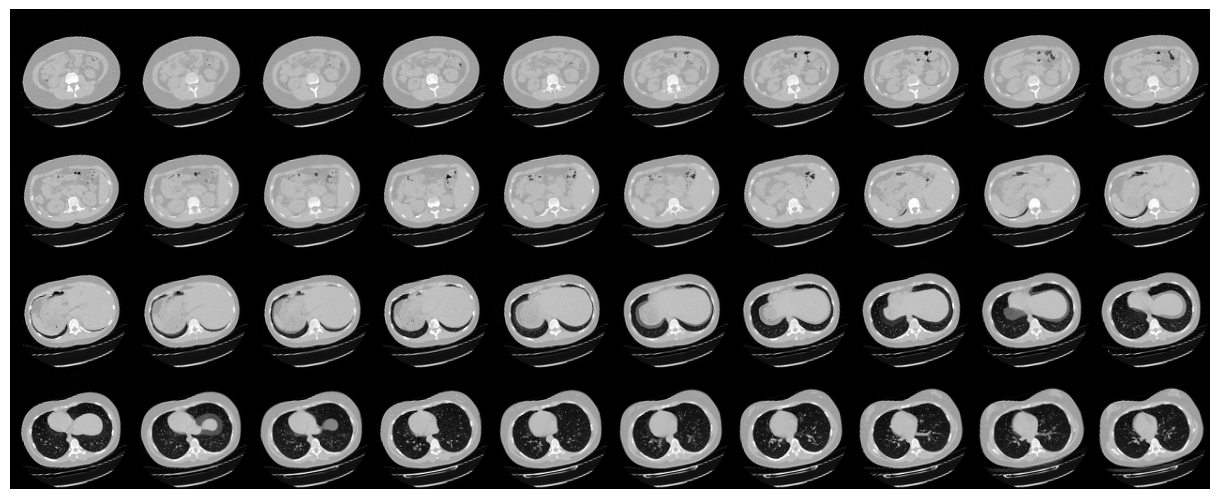

In [11]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

In [3]:
def get_model(width=128, height=128, depth=64):
    inputs = keras.Input((width, height, depth, 1))
    x = layers.Conv3D(64, 3, activation = "relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(64, 3, activation = "relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(128, 3, activation = "relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(256, 3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs, name="3dcnn")
    model.compile(optimizer = "adam", loss = keras.losses.BinaryCrossentropy(from_logits=True))
    return model

In [4]:
model = get_model()
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             